# Spectral analysis example notebook

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html). Based on a datasets of 4 crabs runs we will perform a full region based spectral analysis, i.e. extracting source and background counts from certain regions, and fitting them using the forward-folding approach.

## Load Data

First, we need to select some observations for our spectral analysis. To this end we use the [data management](http://docs.gammapy.org/en/latest/data/dm.html) functionality in gammapy. The following example uses a simulated crab dataset in [gammapy-extra](https://github.com/gammapy/gammapy-extra). Ideally, we'd use crabs runs from the H.E.S.S. public data release, so if you have the released files just change the ``DATA_DIR`` variable to the corresponding folder.

In [1]:
from gammapy.data import DataStore, ObservationList

DATA_DIR = '$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2'

datastore = DataStore.from_dir(DATA_DIR)
obs_ids = [23523, 23526, 23559, 23592]

observations = ObservationList(datastore.obs(obs_id) for obs_id in obs_ids)
print(observations[0])

Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %



## Define Target Region

The next step is to define a signal extraction region, also known as on region. In the simplest case this is just a [CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html#regions.CircleSkyRegion), but here we will use the ``Target`` class in gammapy that is useful for book-keeping if you run several analysis in a script.

In [2]:
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import Target

target_position = SkyCoord(ra=83.63, dec=22.01, unit='deg', frame='icrs')
on_region_radius = Angle('0.2 deg')
on_region = CircleSkyRegion(center=target_position, radius = on_region_radius)

target = Target(on_region = on_region, name='Crab', tag='crab_example')
print(target)

Target: Crab
Tag: crab_example
On region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63, 22.01)>
radius: 0.2 deg



## Load exclusion mask

Most analysis will require a mask to exclude regions with possible gamma-ray signal from the background estimation procedure. For simplicity, we will use a pre-cooked exclusion mask from gammapy-extra which includes (or rather excludes) all source listed in the [TeVCat](http://tevcat.uchicago.edu/) and cutout only the region around the crab.

TODO: Change to [gamma-cat](https://gammapy.github.io/gamma-cat/)

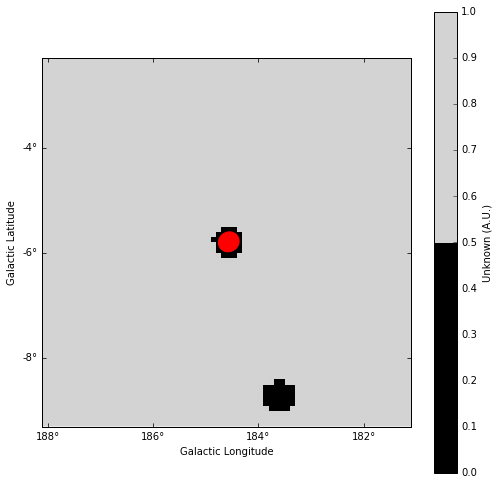

In [3]:
%matplotlib inline
from gammapy.image import SkyMask
import matplotlib.pyplot as plt

EXCLUSION_FILE = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'

allsky_mask = SkyMask.read(EXCLUSION_FILE)
exclusion_mask = allsky_mask.cutout(position=target.on_region.center, size = Angle('7 deg'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=exclusion_mask.wcs)
exclusion_mask.plot(fig=fig, ax=ax)
target.on_region.plot(ax=ax, color='red')


## Estimate background

Next we will manually perform a background estimate by placing [reflected regions](http://docs.gammapy.org/en/latest/background/reflected.html) around the pointing position and looking at the source statistics. In a real analysis you probably don't want to this every time. In this case you can also pass the background estimation parameters directly to the ``SpectrumExtraction`` class, as shown below in [Extract Spectrum](#extract_spectrum).

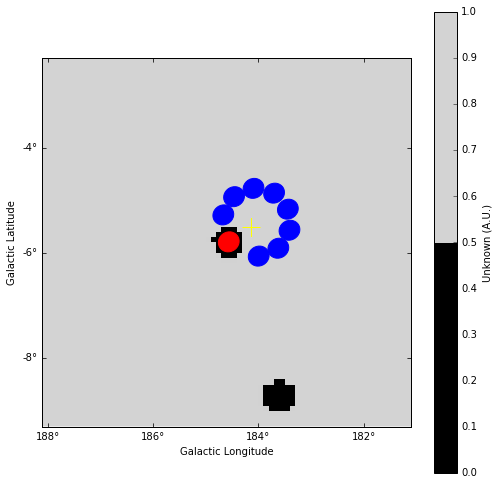

In [4]:
from gammapy.background import reflected_regions_background_estimate

bkg = [reflected_regions_background_estimate(on_region=target.on_region,
                                            pointing=obs.pointing_radec,
                                            exclusion=exclusion_mask,
                                            events=obs.events) for obs in observations]

test_obs = 1
test_pointing = observations[test_obs].pointing_radec

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=exclusion_mask.wcs)
exclusion_mask.plot(fig=fig, ax=ax)
target.on_region.plot(ax=ax, color='red')

# without this the axis limits are changed when calling scatter
ax.autoscale(enable=False)
ax.scatter(test_pointing.galactic.l, test_pointing.galactic.b,
           transform=ax.get_transform('galactic'),
           marker='+', color='yellow', s=300)
for off in bkg[test_obs].off_region:
    off.plot(ax=ax, color='blue')

## Source statistic

Next we're going to look at the overall source statistics in our signal region. For more info about what debug plots you can create check out the [ObservationSummary](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationSummary.html#gammapy.data.ObservationSummary) class.

*** Observation summary report ***
Observation Id: 23526
Livetime: 0.437 h
On events: 200
Off events: 148
Alpha: 0.125
Bkg events in On region: 18.50
Excess: 181.50
Excess / Background: 9.81
Gamma rate: 7.63 1 / min
Bkg rate: 0.71 1 / min
Sigma: 20.96



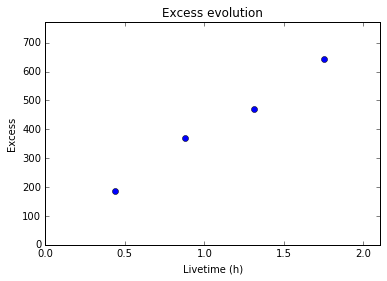

In [5]:
from gammapy.data import ObservationStats, ObservationSummary

stats = list()
for _obs, _bkg in zip(observations, bkg):
    stats.append(ObservationStats.from_target(_obs, target, _bkg))
    
print(stats[1])

obs_summary=ObservationSummary(stats)
obs_summary.plot_excess_vs_livetime()

## Extract spectrum

<a id='extract_spectrum'></a>

Finally, we're going to extract a spectrum using the [SpectrumExtratction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html) class. Since most of the time you probably want to go directly to this step, we'll assume you just defined all your input data, but not performed any background estimation. Therefore you have to pass the background estimation parameters as a dict to the ``SpectrumExtraction`` instance. The ``run`` method executes all steps of the extraction process and saves the results in the folder ``ANALYSIS_DIR``.

In [6]:
from gammapy.spectrum import SpectrumExtraction

ANALYSIS_DIR = 'crab_analysis'

bkg_estimation = dict(
    method='reflected',
    exclusion=exclusion_mask
)

extraction = SpectrumExtraction(target = target,
                                obs = observations,
                                background = bkg_estimation)
extraction.run(outdir=ANALYSIS_DIR)

## Look at observations

At this point we could proceed and fit a global model to the spectrum we just extraced. However, we will take a short moment to have a look at the files we just created. The ``crab_analysis`` directory contains a folder called ``ogip_data``. In this folder you find 4 ``FITS`` files for each observation. These files are described in detail at https://gamma-astro-data-formats.readthedocs.io/en/latest/ogip/index.html. In short they correspond to the on vector, the off vector, the effectie area, and the energy dispersion.

TODO: Plot is shown 2 times - Fix

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


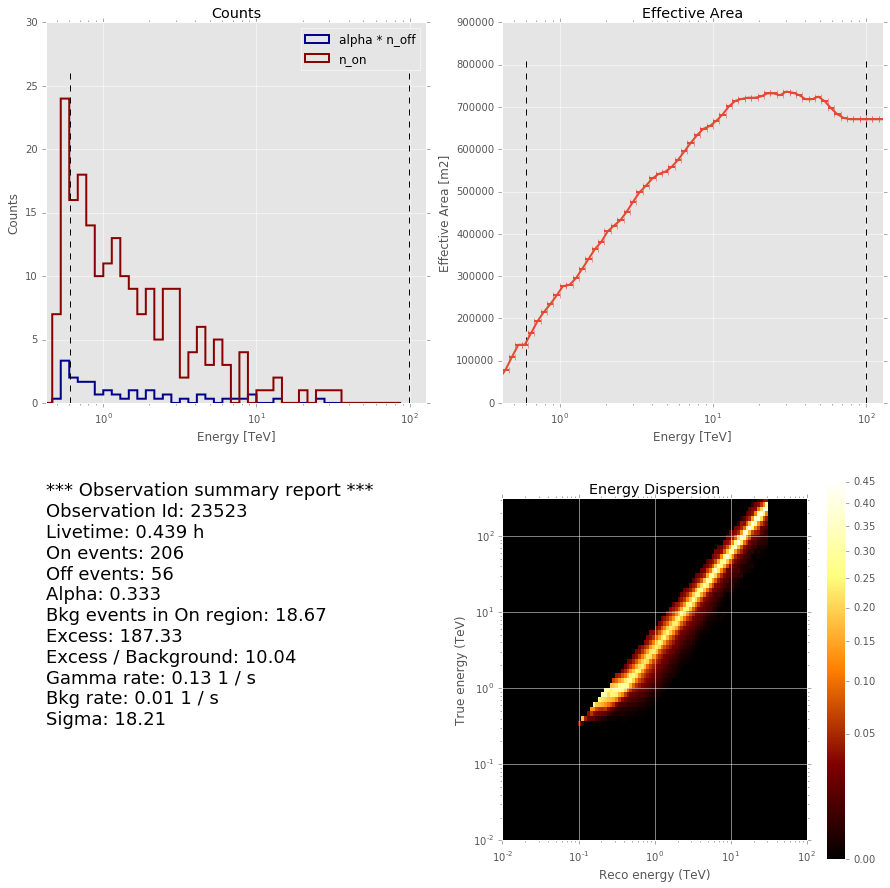

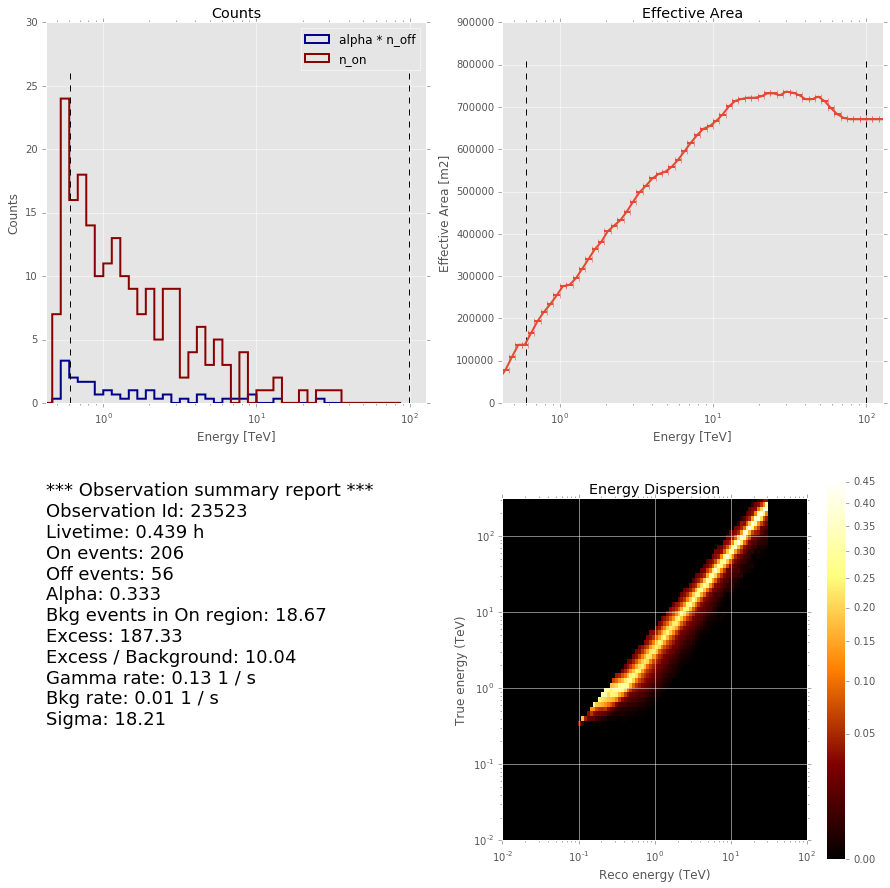

In [7]:
from gammapy.spectrum import SpectrumObservation
from gammapy.utils.scripts import make_path

ana_dir = make_path(ANALYSIS_DIR)

obs = SpectrumObservation.read(ana_dir / 'ogip_data' / 'pha_obs23523.fits')
obs.peek()

## Fit spectrum

Now we'll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.


Fit result info 
--------------- 
Model: PowerLaw
index : 2.25+/-0.05
reference : 1
amplitude : (2.37+/-0.11)e-07 

Statistic: 175.877 (wstat)
Covariance:
[u'index', u'amplitude']
[[  2.04983805e-03   2.33842464e-10]
 [  2.33842464e-10   1.30490418e-16]]
Fit Range: [  0.49582929  82.70931131] TeV



(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f16e78650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f165a4250>)

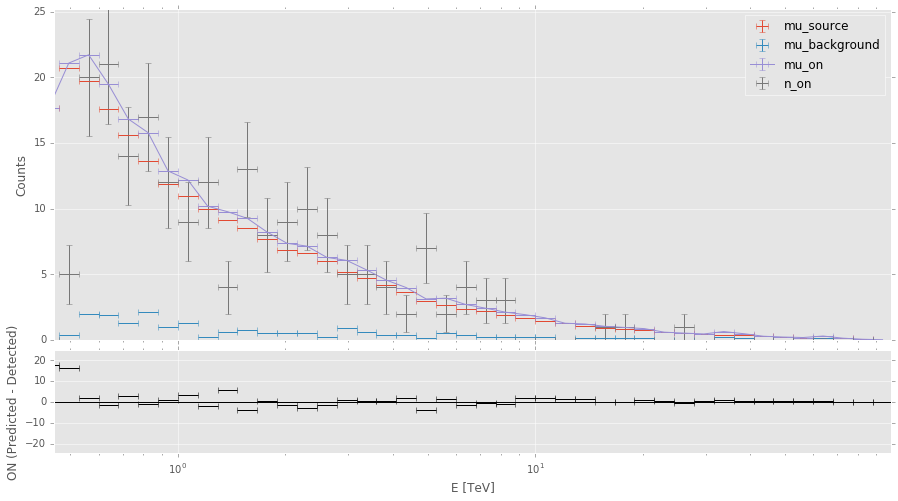

In [8]:
from gammapy.spectrum import SpectrumFit
from gammapy.spectrum. models import PowerLaw
import astropy.units as u

model = PowerLaw(index = 2 * u.Unit(''),
                amplitude = 2e-11 * u.Unit('cm-2 s-1 TeV-1'),
                reference = 1 * u.TeV)

fit = SpectrumFit(extraction.observations, model)
fit.run(outdir = ANALYSIS_DIR)

print(fit.global_result)
fit.result[1].plot()



## Compute Flux Points

To round up out analysis we can compute flux points by fitting the norm of the global model in energy bands. To get a sensible energy binning we require a 4 sigma detection in each energy band.

/home/kingj/Software/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


[  0.46415888   0.59948425   0.77426368   1.           1.29154967
   1.66810054   2.15443469   2.7825594    3.59381366   4.64158883
   5.9948425    7.74263683  10.          14.67799268  21.5443469
  99.08319449] TeV


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f0f572650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f169bb5d0>)

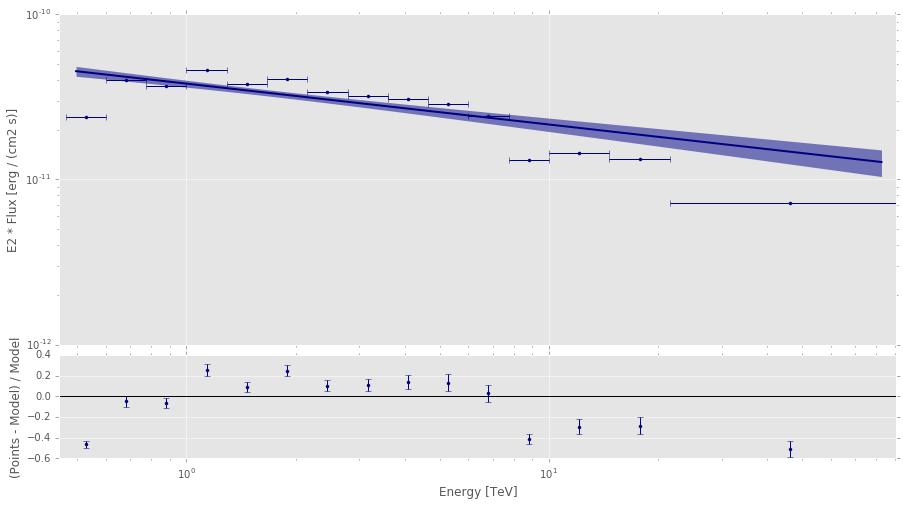

In [9]:
from gammapy.spectrum.utils import calculate_flux_point_binning
from gammapy.spectrum import DifferentialFluxPoints

binning = calculate_flux_point_binning(obs_list=extraction.observations, min_signif=4)
print(binning)

spectrum_result = fit.compute_fluxpoints(binning=binning)
spectrum_result.plot(energy_range=fit.global_result.fit_range, energy_power=2, flux_unit='erg-1 cm-2 s-1')

## Stack observations

And alternative approach to fitting the spectrum is stacking all observations first and the fitting a model to the stacked observation. This works as follows. A comparison to the joint likelihood fit is also printed.

In [10]:
from astropy.table import vstack

stacked_obs = SpectrumObservation.stack(extraction.observations)
stacked_fit = SpectrumFit(stacked_obs, model)

stacked_fit.fit()
print(stacked_fit.result[0])

stacked_table = stacked_fit.result[0].to_table(format='.3g')
stacked_table['method'] = 'stacked'
joint_table = fit.global_result.to_table(format='.3g')
joint_table['method'] = 'joint'
print(vstack([stacked_table, joint_table])['method', 'index', 'index_err', 'amplitude', 'amplitude_err'])


Fit result info 
--------------- 
Model: PowerLaw
index : 2.25+/-0.04
reference : 1
amplitude : (2.42+/-0.11)e-07 

Statistic: 74.847 (wstat)
Covariance:
[u'index', u'amplitude']
[[  1.97004124e-03   2.29785428e-10]
 [  2.29785428e-10   1.30052624e-16]]
Fit Range: [  0.49582929  82.70931131] TeV

 method index index_err    amplitude     amplitude_err 
                        1 / (cm2 s TeV) 1 / (cm2 s TeV)
------- ----- --------- --------------- ---------------
stacked  2.25    0.0444        2.42e-11        1.14e-12
  joint  2.25    0.0453        2.37e-11        1.14e-12
